# Forecasting With Tensorflow: Comparing Model Architectures

This notebook formulates a multi-variable forecasting problem to predict the next 9 months of Volume.

Here I compare the forecasting performance of using several different model types. Each model uses the same final two DNN layers with dropout. One of 128 units, and the final layer of 24 (the output horizon). Each of the models unique layers are:

1. A three layer DNN (one layer plus the common bottom two layers)
2. A CNN with two layers of 1D convolutions with max pooling.
3. A LSTM with two LSTM layers.
4. A CNN stacked LSTM with layers from models 2 and 3 feeding into the common DNN layer.
5. A CNN stacked LSTM with a skip connection to the common DNN layer. 

Each model is compared against baseline persistance models consisting of a one month persistence, and a three month average persistence. Also compared is the TFT error. 

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
main_dataset = pd.read_csv("drive/MyDrive/data_processed_plant_item_encoded_13_03_22.csv")

In [ ]:
# Load data from Tensors
actual = np.load('drive/MyDrive/Tensors/actual_sales.npy', allow_pickle=True)
ARIMA = np.load('drive/MyDrive/Tensors/ARIMA_predictions.npy', allow_pickle=True)
dual_TFT = np.load('drive/MyDrive/Tensors/dual_TFT_preds.npy', allow_pickle=True)
LSTM = np.load('drive/MyDrive/Tensors/LSTM_predictions.npy', allow_pickle=True)
multi_TFT_v3 = np.load('drive/MyDrive/Tensors/multi_TFT_preds_V3.npy', allow_pickle=True)
TFT_encoded = np.load('drive/MyDrive/Tensors/TFT_encoded_predictions.npy', allow_pickle=True)
TFT_predictions = np.load('drive/MyDrive/Tensors/TFT_predictions.npy', allow_pickle=True)
TFT_predictions_v2 = np.load('drive/MyDrive/Tensors/TFT_predictions_17_03_22.npy', allow_pickle=True)
naive_predictions = np.load('drive/MyDrive/Tensors/baseline_predictions.npy', allow_pickle=True)


In [ ]:
main_dataset

,Unnamed: 0,index,ParentItemID,PlantID,Volume,Date,time_idx,month,log_volume,log_ret,...,std_volume_by_material,avg_volume_by_plant,max_volume_by_plant,min_volume_by_plant,std_volume_by_plant,timeseries,index.1,encoding_1,encoding_2,encoding_3
0,0,6636,AI19565015TWICA22,5M01,4,2019-02-01,0,2,1.386294,19.806975,...,20,165.928938,15669,0,387610,80,0,-2.143119,-2.801999,0.320237
1,1,6637,AI19565015TWICA22,5M01,0,2019-03-01,1,3,-18.420681,-19.806975,...,0,248.715325,20517,0,580999,80,1,-2.143119,-2.801999,0.320237
2,2,6638,AI19565015TWICA22,5M01,0,2019-04-01,2,4,-18.420681,0.000000,...,0,146.664384,15601,0,342608,80,2,-2.143119,-2.801999,0.320237
3,3,6639,AI19565015TWICA22,5M01,0,2019-05-01,3,5,-18.420681,0.000000,...,4,151.811216,16898,0,354631,80,3,-2.143119,-2.801999,0.320237
4,4,6640,AI19565015TWICA22,5M01,52,2019-06-01,4,6,3.951244,22.371924,...,140,193.533818,21201,0,452095,80,4,-2.143119,-2.801999,0.320237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365780,365780,2906682,AP35525024YUPRA02,5M01,0,2021-08-01,30,8,-18.420681,0.000000,...,0,123.659675,10203,0,288869,34604,365780,0.000000,0.000000,0.000000
365781,365781,2906683,AP35525024YUPRA02,5M01,0,2021-09-01,31,9,-18.420681,0.000000,...,0,138.864726,8513,0,324388,34604,365781,0.000000,0.000000,0.000000
365782,365782,2906684,AP35525024YUPRA02,5M01,0,2021-10-01,32,10,-18.420681,0.000000,...,0,148.225599,9116,0,346255,34604,365782,0.000000,0.000000,0.000000
365783,365783,2906685,AP35525024YUPRA02,5M01,0,2021-11-01,33,11,-18.420681,0.000000,...,0,112.859161,5929,0,263639,34604,365783,0.000000,0.000000,0.000000


# Baseline Error Performance

In order to compare model perofrmance we need an estimate of bayes limit for the problem. In this case we do not have a human error reference. So we use the the lowest of the following:
- APO recorded forecast. This is the collection of models used by the sales team (when we receive it that is)
- Persistance 1 month. Using the observed values from the previous months as the prediction of the next month. This is the Naive Forecast
- Persistance 3 month mean. Using the observations from the previous 3 months as the prediction of the next month.

By establishing a baseline error we have a refernce to compare our training and validation set performance. This guides us to understand where and how a model is performance. For example, if our bayes error is MAE 5% and our model training and validation perform at MAE 6% and 9% respectively then the relevant obserevation is that our model performs with high variance with respect to the baseline. The contrary is true if we consider baseline, train, and validation MAEs of 5%, 8%, and 8.5% respectively. In the latter case we should work on the bias of the training set before considering the validation performance (low variance).

In [ ]:
main_dataset['perisitence_1'] = main_dataset['Volume'].shift(1)
main_dataset['perisitence_2'] = main_dataset['Volume'].shift(2)
main_dataset['perisitence_3'] = main_dataset['Volume'].shift(3)
main_dataset['perisitence_3_mean'] = (main_dataset['perisitence_1'] + main_dataset['perisitence_2'] + main_dataset['perisitence_3']) / 3 

In [ ]:
# Filter by relevant Timesteps for predictions that have been made
subset_of_main_data = main_dataset[['ParentItemID', 'PlantID', 'time_idx', 'timeseries', 'Volume', 'perisitence_1', 'perisitence_3_mean']]
subset_of_main_data = subset_of_main_data[subset_of_main_data['time_idx'].isin([29, 30, 31, 32, 33, 34])]
subset_of_main_data = subset_of_main_data.reset_index()

# Add in the datasets from Tensors
subset_of_main_data['actuals_output'] = np.array(actual).flatten()
subset_of_main_data['naive_predictions'] = np.array(naive_predictions).flatten()
subset_of_main_data['TFT_predictions'] = np.array(TFT_predictions).flatten()

subset_of_main_data['ARIMA'] = np.array(ARIMA).flatten()
subset_of_main_data['dual_TFT'] = np.array(dual_TFT).flatten()
subset_of_main_data['LSTM'] = np.array(LSTM).flatten()
subset_of_main_data['multi_TFT_v3'] = np.array(multi_TFT_v3).flatten()
subset_of_main_data['TFT_encoded'] = np.array(TFT_encoded).flatten()
subset_of_main_data['TFT_predictions_v2'] = np.array(TFT_predictions_v2).flatten()

# Check that Actual is done properly
print(f"The difference between Actual Output and Original is:  {(subset_of_main_data['actuals_output'] - subset_of_main_data['Volume']).sum()}")

# Check for NaN's in Dataset. If there were nans, we would fill nans with linear interpolation because this is how we will fill when using the data in the models.
if sum(list(main_dataset.isna().sum())) > 0:
  print('\033[93m You have NaN\'s in your main_dataset dataset')

if sum(list(subset_of_main_data.isna().sum())) > 0:
  print('\033[93m You have NaN\'s in your subset_of_main_data dataset')


The difference between Actual Output and Original is:  0.0
 You have NaN's in your main_dataset dataset


In [ ]:
aggregate = subset_of_main_data.groupby(['ParentItemID', 'time_idx']).agg('sum')
aggregate.drop(['index', 'timeseries'], axis=1, inplace=True)

In [ ]:
subset_of_main_data.columns

Index(['index', 'ParentItemID', 'PlantID', 'time_idx', 'timeseries', 'Volume',
       'perisitence_1', 'perisitence_3_mean', 'actuals_output',
       'naive_predictions', 'TFT_predictions', 'ARIMA', 'dual_TFT', 'LSTM',
       'multi_TFT_v3', 'TFT_encoded', 'TFT_predictions_v2'],
      dtype='object')

In [ ]:
def MAE(dataset, forecast):
  return tf.keras.losses.MAE(dataset["Volume"], dataset[forecast]).numpy()

In [ ]:
def WMAPE(dataset, forecast):
  WMAPE_output = (( abs(  dataset[forecast] - dataset['actuals_output']  ) ).sum() / dataset['actuals_output'].sum()) * 100
  return WMAPE_output

# Weighted Quantile Loss (wQL)
The Weighted Quantile Loss (wQL) metric measures the accuracy of a model at a specified quantile. It is particularly useful when there are different costs for underpredicting and overpredicting. By setting the weight (τ) of the wQL function, you can automatically incorporate differing penalties for underpredicting and overpredicting.

The loss function is calculated as follows:

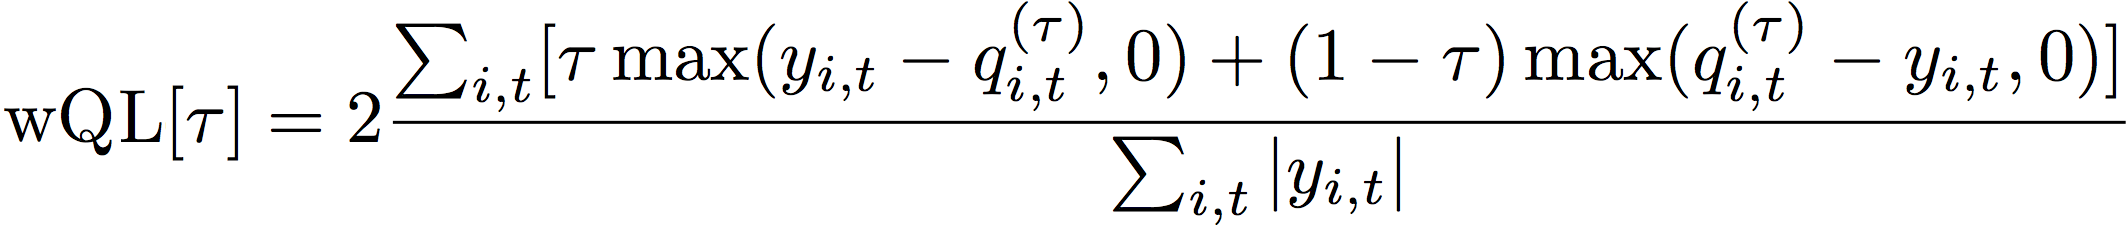

Where:
τ - a quantile in the set {0.01, 0.02, ..., 0.99}

qi,t(τ) - the τ-quantile that the model predicts.

yi,t - the observed value at point (i,t)


The quantiles (τ) for wQL can range from 0.01 (P1) to 0.99 (P99). The wQL metric cannot be calculated for the mean forecast.

By default, Forecast computes wQL at 0.1 (P10), 0.5 (P50), and 0.9 (P90).

- P10 (0.1) - The true value is expected to be lower than the predicted value 10% of the time.

- P50 (0.5) - The true value is expected to be lower than the predicted value 50% of the time. This is also known as the median forecast.

- P90 (0.9) - The true value is expected to be lower than the predicted value 90% of the time.

In retail, the cost of being understocked is often higher than the cost of being overstocked, and so forecasting at P75 (τ = 0.75) can be more informative than forecasting at the median quantile (P50). In these cases, wQL[0.75] assigns a larger penalty weight to underforecasting (0.75) and a smaller penalty weight to overforecasting (0.25).

Amazon Forecast also calculates the average wQL, which is the mean value of weighted quantile losses over all specified quantiles. By default, this will be the average of wQL[0.10], wQL[0.50], and wQL[0.90].

In [ ]:
def wQL(dataset, forecast, tau):
  array_max_yit_qit_0 = np.where((dataset["Volume"] -  dataset[forecast]) > 0, (dataset["Volume"] -  dataset[forecast]) , 0)
  array_max_qit_yit_0 = np.where(( dataset[forecast] - dataset["Volume"]) > 0, ( dataset[forecast] - dataset["Volume"]) , 0)
  return 200*( (sum(  tau * array_max_yit_qit_0 + (1-tau) * array_max_qit_yit_0  ))  /   (sum(  dataset["Volume"]  ))  )

In [ ]:
def meanWQL(dataset, forecast):
  return (wQL(dataset, forecast, 0.1) + wQL(dataset, forecast, 0.5) + wQL(dataset, forecast, 0.9))/3

In [ ]:
list_of_forecasts =  [
                     #  'APO_forecast', 'SalesHead_Corr_Forecast', 
                     'naive_predictions', 'perisitence_1', 'perisitence_3_mean',
                     'actuals_output', 'TFT_predictions', 'ARIMA', 'dual_TFT', 
                     'LSTM', 'multi_TFT_v3', 'TFT_encoded', 'TFT_predictions_v2'
                     ]

In [ ]:

ref_error = pd.DataFrame({
    "Method": list_of_forecasts,
    "MAE": [
            MAE(subset_of_main_data, list_of_forecasts[0]),
            MAE(subset_of_main_data, list_of_forecasts[1]),
            MAE(subset_of_main_data, list_of_forecasts[2]),
            MAE(subset_of_main_data, list_of_forecasts[3]),
            MAE(subset_of_main_data, list_of_forecasts[4]),
            MAE(subset_of_main_data, list_of_forecasts[5]),
            MAE(subset_of_main_data, list_of_forecasts[6]),
            MAE(subset_of_main_data, list_of_forecasts[7]),
            MAE(subset_of_main_data, list_of_forecasts[8]),
            MAE(subset_of_main_data, list_of_forecasts[9]),
            MAE(subset_of_main_data, list_of_forecasts[10])],
    "WMAPE":[
            WMAPE(subset_of_main_data, list_of_forecasts[0]),
            WMAPE(subset_of_main_data, list_of_forecasts[1]),
            WMAPE(subset_of_main_data, list_of_forecasts[2]),
            WMAPE(subset_of_main_data, list_of_forecasts[3]), 
            WMAPE(subset_of_main_data, list_of_forecasts[4]), 
            WMAPE(subset_of_main_data, list_of_forecasts[5]), 
            WMAPE(subset_of_main_data, list_of_forecasts[6]), 
            WMAPE(subset_of_main_data, list_of_forecasts[7]), 
            WMAPE(subset_of_main_data, list_of_forecasts[8]), 
            WMAPE(subset_of_main_data, list_of_forecasts[9]), 
            WMAPE(subset_of_main_data, list_of_forecasts[10])],
     "Aggregated WMAPE":[
            WMAPE(aggregate, list_of_forecasts[0]),
            WMAPE(aggregate, list_of_forecasts[1]),
            WMAPE(aggregate, list_of_forecasts[2]),
            WMAPE(aggregate, list_of_forecasts[3]), 
            WMAPE(aggregate, list_of_forecasts[4]), 
            WMAPE(aggregate, list_of_forecasts[5]), 
            WMAPE(aggregate, list_of_forecasts[6]), 
            WMAPE(aggregate, list_of_forecasts[7]), 
            WMAPE(aggregate, list_of_forecasts[8]), 
            WMAPE(aggregate, list_of_forecasts[9]), 
            WMAPE(aggregate, list_of_forecasts[10])],
    "wQL[0.1]":[
            wQL(subset_of_main_data, list_of_forecasts[0], 0.1),
            wQL(subset_of_main_data, list_of_forecasts[1], 0.1),
            wQL(subset_of_main_data, list_of_forecasts[2], 0.1),
            wQL(subset_of_main_data, list_of_forecasts[3], 0.1), 
            wQL(subset_of_main_data, list_of_forecasts[4], 0.1), 
            wQL(subset_of_main_data, list_of_forecasts[5], 0.1), 
            wQL(subset_of_main_data, list_of_forecasts[6], 0.1), 
            wQL(subset_of_main_data, list_of_forecasts[7], 0.1), 
            wQL(subset_of_main_data, list_of_forecasts[8], 0.1), 
            wQL(subset_of_main_data, list_of_forecasts[9], 0.1), 
            wQL(subset_of_main_data, list_of_forecasts[10], 0.1)],
    "wQL[0.5] (WMAPE)":[
            wQL(subset_of_main_data, list_of_forecasts[0], 0.5),
            wQL(subset_of_main_data, list_of_forecasts[1], 0.5),
            wQL(subset_of_main_data, list_of_forecasts[2], 0.5),
            wQL(subset_of_main_data, list_of_forecasts[3], 0.5), 
            wQL(subset_of_main_data, list_of_forecasts[4], 0.5), 
            wQL(subset_of_main_data, list_of_forecasts[5], 0.5), 
            wQL(subset_of_main_data, list_of_forecasts[6], 0.5), 
            wQL(subset_of_main_data, list_of_forecasts[7], 0.5), 
            wQL(subset_of_main_data, list_of_forecasts[8], 0.5), 
            wQL(subset_of_main_data, list_of_forecasts[9], 0.5), 
            wQL(subset_of_main_data, list_of_forecasts[10], 0.5)],
    "wQL[0.75]":[
            wQL(subset_of_main_data, list_of_forecasts[0], 0.75),
            wQL(subset_of_main_data, list_of_forecasts[1], 0.75),
            wQL(subset_of_main_data, list_of_forecasts[2], 0.75),
            wQL(subset_of_main_data, list_of_forecasts[3], 0.75), 
            wQL(subset_of_main_data, list_of_forecasts[4], 0.75), 
            wQL(subset_of_main_data, list_of_forecasts[5], 0.75), 
            wQL(subset_of_main_data, list_of_forecasts[6], 0.75), 
            wQL(subset_of_main_data, list_of_forecasts[7], 0.75), 
            wQL(subset_of_main_data, list_of_forecasts[8], 0.75), 
            wQL(subset_of_main_data, list_of_forecasts[9], 0.75), 
            wQL(subset_of_main_data, list_of_forecasts[10], 0.75)],
    "wQL[0.9]":[
            wQL(subset_of_main_data, list_of_forecasts[0], 0.9),
            wQL(subset_of_main_data, list_of_forecasts[1], 0.9),
            wQL(subset_of_main_data, list_of_forecasts[2], 0.9),
            wQL(subset_of_main_data, list_of_forecasts[3], 0.9), 
            wQL(subset_of_main_data, list_of_forecasts[4], 0.9), 
            wQL(subset_of_main_data, list_of_forecasts[5], 0.9), 
            wQL(subset_of_main_data, list_of_forecasts[6], 0.9), 
            wQL(subset_of_main_data, list_of_forecasts[7], 0.9), 
            wQL(subset_of_main_data, list_of_forecasts[8], 0.9), 
            wQL(subset_of_main_data, list_of_forecasts[9], 0.9), 
            wQL(subset_of_main_data, list_of_forecasts[10], 0.9)],
    "Mean wQL":[
            meanWQL(subset_of_main_data, list_of_forecasts[0]),
            meanWQL(subset_of_main_data, list_of_forecasts[1]),
            meanWQL(subset_of_main_data, list_of_forecasts[2]),
            meanWQL(subset_of_main_data, list_of_forecasts[3]), 
            meanWQL(subset_of_main_data, list_of_forecasts[4]), 
            meanWQL(subset_of_main_data, list_of_forecasts[5]), 
            meanWQL(subset_of_main_data, list_of_forecasts[6]), 
            meanWQL(subset_of_main_data, list_of_forecasts[7]), 
            meanWQL(subset_of_main_data, list_of_forecasts[8]), 
            meanWQL(subset_of_main_data, list_of_forecasts[9]), 
            meanWQL(subset_of_main_data, list_of_forecasts[10])]
            
            
                   }, 
    index=[i for i in range(len(list_of_forecasts))])

In [ ]:
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', 'white'), ('color', 'black')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #8900f2; color: white;'
}

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

def highlight_compare(s, props=''):
    return np.where(s > s[0], props, '')

def highlight_compare2(s, props=''):
    return np.where(s < s[0], props, '')


s = ref_error.style
s = s.set_table_styles([cell_hover, index_names, headers])

# DataFrame maximum in red, and column maximums in orange.

s.apply(highlight_max, props='color:white;background-color:orange;', subset=pd.IndexSlice[:, ['MAE', 'WMAPE', 'Aggregated WMAPE', 'wQL[0.1]', 'wQL[0.5] (WMAPE)', 'wQL[0.75]', 'wQL[0.9]', 'Mean wQL' ]], axis=0)\
  .apply(highlight_max, props='color:white;background-color:red', subset=pd.IndexSlice[:, ['MAE', 'WMAPE', 'Aggregated WMAPE', 'wQL[0.1]', 'wQL[0.5] (WMAPE)', 'wQL[0.75]', 'wQL[0.9]', 'Mean wQL' ]], axis=None)\
  .apply(highlight_compare, props='color:#961c00;',subset=pd.IndexSlice[:, ['MAE', 'WMAPE', 'Aggregated WMAPE', 'wQL[0.1]', 'wQL[0.5] (WMAPE)', 'wQL[0.75]', 'wQL[0.9]', 'Mean wQL' ]], axis=0)\
  .apply(highlight_compare2, props='color:green;',subset=pd.IndexSlice[:, ['MAE', 'WMAPE', 'Aggregated WMAPE', 'wQL[0.1]', 'wQL[0.5] (WMAPE)', 'wQL[0.75]', 'wQL[0.9]', 'Mean wQL' ]], axis=0)\
  .set_properties(**{'background-color': '#8900f2', 'font-weight':'bold'}, subset=pd.IndexSlice[:, ['Method']])

print('DataFrame maximum in red, and column maximums in orange. If metric is larger than Naive i.e.[0] for that metric, text is dark red')
print('\033[93m Summary of errors:')
s

DataFrame maximum in red, and column maximums in orange. If metric is larger than Naive i.e.[0] for that metric, text is dark red
 Summary of errors:


,Method,MAE,WMAPE,Aggregated WMAPE,wQL[0.1],wQL[0.5] (WMAPE),wQL[0.75],wQL[0.9],Mean wQL
0,naive_predictions,40.568352,84.304947,62.370169,72.118935,84.304947,91.921204,96.490958,84.304947
1,perisitence_1,34.615874,71.935126,51.168809,72.828774,71.935126,71.376596,71.041477,71.935126
2,perisitence_3_mean,31.739148,65.957011,49.521603,60.205735,65.957011,69.551559,71.708287,65.957011
3,actuals_output,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TFT_predictions,33.828964,70.299852,52.658886,58.658150,70.299853,77.575918,81.941556,70.299853
5,ARIMA,38.716288,80.456181,60.125219,67.920708,80.456181,88.290852,92.991654,80.456181
6,dual_TFT,32.955994,68.485731,50.727862,53.658952,68.485731,77.752468,83.312510,68.485731
7,LSTM,79.530865,165.272810,131.944945,210.120375,165.272810,137.243082,120.425246,165.272810
8,multi_TFT_v3,33.468410,69.550592,51.732665,56.630357,69.550588,77.625732,82.470818,69.550588
9,TFT_encoded,35.110306,72.962606,57.054043,54.936580,72.962604,84.228869,90.988628,72.962604


# Preparing the Data

We will use tf.datasets to prepare the data. The general strategy is to clean, scale, and split the data before creating the tf.dataset object. These steps can alternatively be done within the tf.dataset itself.

***Cleaning data:*** Fill any missing values with a linear interpolation of the value. Same as done in the persistence dataset. Not needed after the check for NaN's

***Scaling data:*** In all cases the data is min max scaled.

***Features:*** As part of this simple analysis of models two feature sets are prepared. The univariate that contains sales only. The multivariate that contains sales, month, plant, material etc .

***Best Practice Original Idea***

***Splitting data:*** 6 months of test data is put aside to evaluate all the models. The train and validation sets are created with a 23/6 split, resulting in 6 month validation samples.

***new***

***Splitting data:*** due to lack of data, 6 months of validation data is put aside to evaluate all the models. The train sets are created with 29 months.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def clean_data(series):
    """Fills missing values. 
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
    return series_filled
        
    
def scale(X):
    # mm = MinMaxScaler()
    mm = StandardScaler()
    X_ = np.atleast_2d(X)
    return pd.DataFrame(mm.fit(X_[:23,:]).transform(X_), X.index)

In [ ]:
# Reset dataset
data = pd.read_csv("drive/MyDrive/data_processed_plant_item_encoded_13_03_22.csv")

In [ ]:
data = clean_data(data)

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.drop(['Unnamed: 0'], axis=1, inplace=True)
for col in ['PlantID', 'ParentItemID']:
    data[col] = data[col].astype(str).astype("category")
data['Volume'] = data['Volume'].astype(float)
data.drop(['month'], axis=1, inplace=True)
data.drop(['index.1'], axis=1, inplace=True)
data["month"] = data.Date.dt.month.astype(str).astype("category")  # categories have be strings

In [ ]:
# Split the Validation and Train dataset by time_index
validations = data[data['time_idx'].isin(list(range(6, 35)))]
train = data[data['time_idx'].isin(list(range(0, 29)))] # generates 0 to 28

# These are the columns to minmax scale. Currently, they are ['Volume', 'log_volume', 'log_ret', 'avg_volume_by_material',
      #  'max_volume_by_material', 'min_volume_by_material',
      #  'std_volume_by_material', 'avg_volume_by_plant', 'max_volume_by_plant',
      #  'min_volume_by_plant', 'std_volume_by_plant', 'encoding_1',
      #  'encoding_2', 'encoding_3']

cols = validations.columns[[3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19]]

validations[cols + '_scaled'] = validations.groupby('timeseries')[cols].apply(scale)
validations.drop(cols, axis=1, inplace=True)
validations.drop(['Date'], axis=1, inplace=True)

train[cols + '_scaled'] = train.groupby('timeseries')[cols].apply(scale)
train.drop(cols, axis=1, inplace=True)
train.drop(['Date'], axis=1, inplace=True)

# One Hot Encode everyting that is categorical or Object # train.dtypes
train = pd.get_dummies(train)
validations = pd.get_dummies(validations)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [ ]:
print("Multivarate Datasets")
print(f"Train Data Shape: {train.shape}")
print(f"Val Data Shape: {validations.shape}")
print(f"Nulls In Train {np.any(np.isnan(train))}")
print(f"Nulls In Validation {np.any(np.isnan(validations))}")

Multivarate Datasets
Train Data Shape: (303079, 1123)
Val Data Shape: (303079, 1123)
Nulls In Train False
Nulls In Validation False


# Windowing the Dataset

Use tf.dataset to create a window dataset. This is a vector of past timesteps (n_steps) that is used to predict on a target vector of future steps (n_horizon). Below shows the output for n_steps = 29 and n_horizon = 6 and the 1000 something features. So we use the last 29 months to predict the next 6 months. 

The resulting shape for X will be (batch size, n_steps, features) and Y will be (batch size, n_horizon, features).

In [ ]:
# Convert to 3d matrices 
validations_matr = np.array(list(validations.groupby('timeseries').apply(pd.DataFrame.to_numpy)))[:,:,3:]
train_matr = np.array(list(train.groupby('timeseries').apply(pd.DataFrame.to_numpy)))[:,:,3:]

In [ ]:
train_matr = train_matr[:1000, :, :2]
validations_matr = validations_matr[:1000, :, :2]

In [ ]:
def window_dataset(matr, n_steps=23, n_horizon=6, batch_size=32, shuffle_buffer=100):
    """ Create a windowed tensorflow dataset
    """
    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon # Should be 29 for us 
    
    #create the inital tensor dataset
    ds = tf.data.Dataset.from_tensor_slices(matr)

    # Shuffle
    ds = ds.shuffle(shuffle_buffer)    
    
    #create the supervised learning problem with x and y and then batch
    ds = ds.map(lambda x : (x[:23, :], x[-6:, 0]))
    ds = ds.batch(batch_size)

    #Final Check
    print(f'Num. of Batchs: {len(ds)} in {ds}')
  
    return ds


In [ ]:
tf.random.set_seed(42)

ds = window_dataset(validations_matr)

print('Example sample shapes')
for idx,(x,y) in enumerate(ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break

Num. of Batchs: 32 in <BatchDataset element_spec=(TensorSpec(shape=(None, 23, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>
Example sample shapes
x =  (32, 23, 2)
y =  (32, 6)


In [ ]:
validations.shape

(303079, 1123)

In [ ]:
validations.columns

Index(['index', 'time_idx', 'timeseries', 'Volume_scaled', 'log_volume_scaled',
       'log_ret_scaled', 'avg_volume_by_material_scaled',
       'max_volume_by_material_scaled', 'min_volume_by_material_scaled',
       'std_volume_by_material_scaled',
       ...
       'month_11', 'month_12', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9'],
      dtype='object', length=1123)

In [ ]:
print(f'Unique timeseries in Validation: {len(validations.timeseries.unique())}')
print(f'Unique time indexed in Validation: {len(validations.time_idx.unique())}')
print(f'number of features: {len(validations.columns) - 3}')

Unique timeseries in Validation: 10451
Unique time indexed in Validation: 29
number of features: 1120


In [ ]:
print(f'Unique timeseries in Validation: {len(train.timeseries.unique())}')
print(f'Unique time indexed in Validation: {len(train.time_idx.unique())}')
print(f'number of features: {len(train.columns) - 3}')

Unique timeseries in Validation: 10451
Unique time indexed in Validation: 29
number of features: 1120


In [ ]:
# Convert to 3d matrices 
validations_matr = np.array(list(validations.groupby('timeseries').apply(pd.DataFrame.to_numpy)))[:,:,3:4]
train_matr = np.array(list(train.groupby('timeseries').apply(pd.DataFrame.to_numpy)))[:,:,3:]

In [ ]:
print(f'Shape of train matrix: {train_matr.shape}')
print(f'Shape of validation matrix: {validations_matr.shape}')

In [ ]:
matr = np.array(list(validations.groupby('timeseries').apply(pd.DataFrame.to_numpy)))

In [ ]:
validations.head(18)

In [ ]:
matr[:,:,3:4]

In [ ]:
def window_dataset(data, batch_size = 32, shuffle_buffer = 10500):
    """ Create a windowed tensorflow dataset
    """

    #create the inital tensor dataset
    ds = tf.data.Dataset.from_tensor_slices(data)
       
    # batch data 
    ds = ds.shuffle(shuffle_buffer)    
    ds = ds.batch(batch_size).prefetch(1) 

    print(f'Num. of Batchs: {len(ds)} in {ds}')
      
    return ds

In [ ]:
tf.random.set_seed(42)

train_ds = window_dataset(train_matr)
validaiton_ds = window_dataset(validations_matr)

In [ ]:
print('Example Batch shapes')
for idx,(x) in enumerate(train_ds):
    print("x = ", x.numpy().shape)
    break

for idx,(x) in enumerate(validaiton_ds):
    print("y = ", x.numpy().shape)
    break

Example Batch shapes


NameError: ignored

# Dataset Loading Function

Wrap the above functions into a single function that allows us to build the dataset in the same way each time.

In [ ]:
np.save('validations_matr.npy', validations_matr)
np.save('train_matr.npy', train_matr)

In [ ]:
def build_dataset():

    tf.random.set_seed(23)
    validations_matr = np.load('validations_matr.npy')
    train_matr  = np.load('train_matr.npy')
    
    # data = pd.read_csv("drive/MyDrive/data_processed_plant_item_encoded_13_03_22.csv")
    # data = clean_data(data)
    # data['Date'] = pd.to_datetime(data['Date'])
    # data.drop(['Unnamed: 0'], axis=1, inplace=True)
    # for col in ['PlantID', 'ParentItemID']:
    #     data[col] = data[col].astype(str).astype("category")
    # data['Volume'] = data['Volume'].astype(float)
    # data.drop(['month'], axis=1, inplace=True)
    # data.drop(['index.1'], axis=1, inplace=True)
    # data["month"] = data.Date.dt.month.astype(str).astype("category")

    # print('\033[92m Data has been loaded from Drive')

    # # Split the Validation and Train dataset by time_index
    # validations = data[data['time_idx'].isin([29, 30, 31, 32, 33, 34])]
    # train = data[data['time_idx'].isin(list(range(0, 29)))] # generates 0 to 28

    # cols = validations.columns[[3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19]]

    # validations[cols + '_scaled'] = validations.groupby('timeseries')[cols].apply(scale)
    # validations.drop(cols, axis=1, inplace=True)
    # validations.drop(['Date'], axis=1, inplace=True)

    # train[cols + '_scaled'] = train.groupby('timeseries')[cols].apply(scale)
    # train.drop(cols, axis=1, inplace=True)
    # train.drop(['Date'], axis=1, inplace=True)

    # print('\033[92m Data has been scaled')


    # # One Hot Encode everyting that is categorical or Object # train.dtypes
    # train = pd.get_dummies(train)
    # validations = pd.get_dummies(validations)

    # print('\033[92m Data has been One Hot Encoded')


    # validations_matr = np.array(list(validations.groupby('timeseries').apply(pd.DataFrame.to_numpy)))[:,:,3:4]
    # train_matr = np.array(list(train.groupby('timeseries').apply(pd.DataFrame.to_numpy)))[:,:,3:]
    print('\033[92m Data has been converted to 3d Matrix')

    train_ds = window_dataset(train_matr)
    print('\033[92m Train tf Dataset generated')
    
    val_ds = window_dataset(validations_matr)
    print('\033[92m Validaiton tf Dataset generated')
    
    print("Datasets:")
    print('\033[92m Train')
    print(train_ds.element_spec)
    print('\033[92m Validation')
    print(val_ds.element_spec)
    
    return train_matr, validations_matr, validations_matr

# Model Configurations

Define a set of model configurations so that we can call and run each model in the same way. The cgf_model_run dictionary will store the model, its history, and the test datasetset generated.

The default model parameters are:
- n_steps: last 29 months
- n_horizon: next 6 months
- learning rate: 3e-4

In [ ]:
def get_params():
    learning_rate = 3e-4
    n_steps=23
    n_horizon=6
    n_features=2

    return n_steps, n_horizon, n_features, learning_rate

model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):
    n_steps, n_horizon, n_features, lr = get_params()
    train_ds, val_ds, test_ds = build_dataset()

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs
    # batch_size =32 
    # callbacks=[CustomCallback()]
    )
    
    model.save(f'./exported_models/{model_name}')

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

# Define Each Model

## DNN
A single 128 unit layer plus the common 128 and 24 unit layyers with dropout.

In [ ]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model


dnn = dnn_model(*get_params())
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 46)                0         
                                                                 
 dense (Dense)               (None, 128)               6016      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 23,302
Trainable params: 23,302
Non-trainable par

## CNN
Two Conv 1D layers with 64 filters each, and kernel sizes of 6 and 3 respectively. After each Conv1D layer a maxpooling1D layer with size of 2. 

In [ ]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

cnn = cnn_model(*get_params())
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 64)            832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dropout (Dropout)           (None, 192)               0       

## LSTM
Two LSTM layers with 72 and 48 units each.

In [ ]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm = lstm_model(*get_params())
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 23, 72)            21600     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774    

## CNN and LSTM Stacked
Using the same layers from the CNN and LSTM model, stack the CNN as input to the pair of LSTMs.

In [ ]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params())
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 64)            832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 3, 72)             39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

## CNN and LSTM with a skip connection
The same CNN and LSTM layers as the previous models this time with a skip connection direct to the common DNN layer.

In [ ]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
   
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_skip = lstm_cnn_skip_model(*get_params())
lstm_skip.summary()

Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 23, 2)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 18, 64)       832         ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 9, 64)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 7, 64)        12352       ['max_pooling1d[0][0]']          
                                                                                          

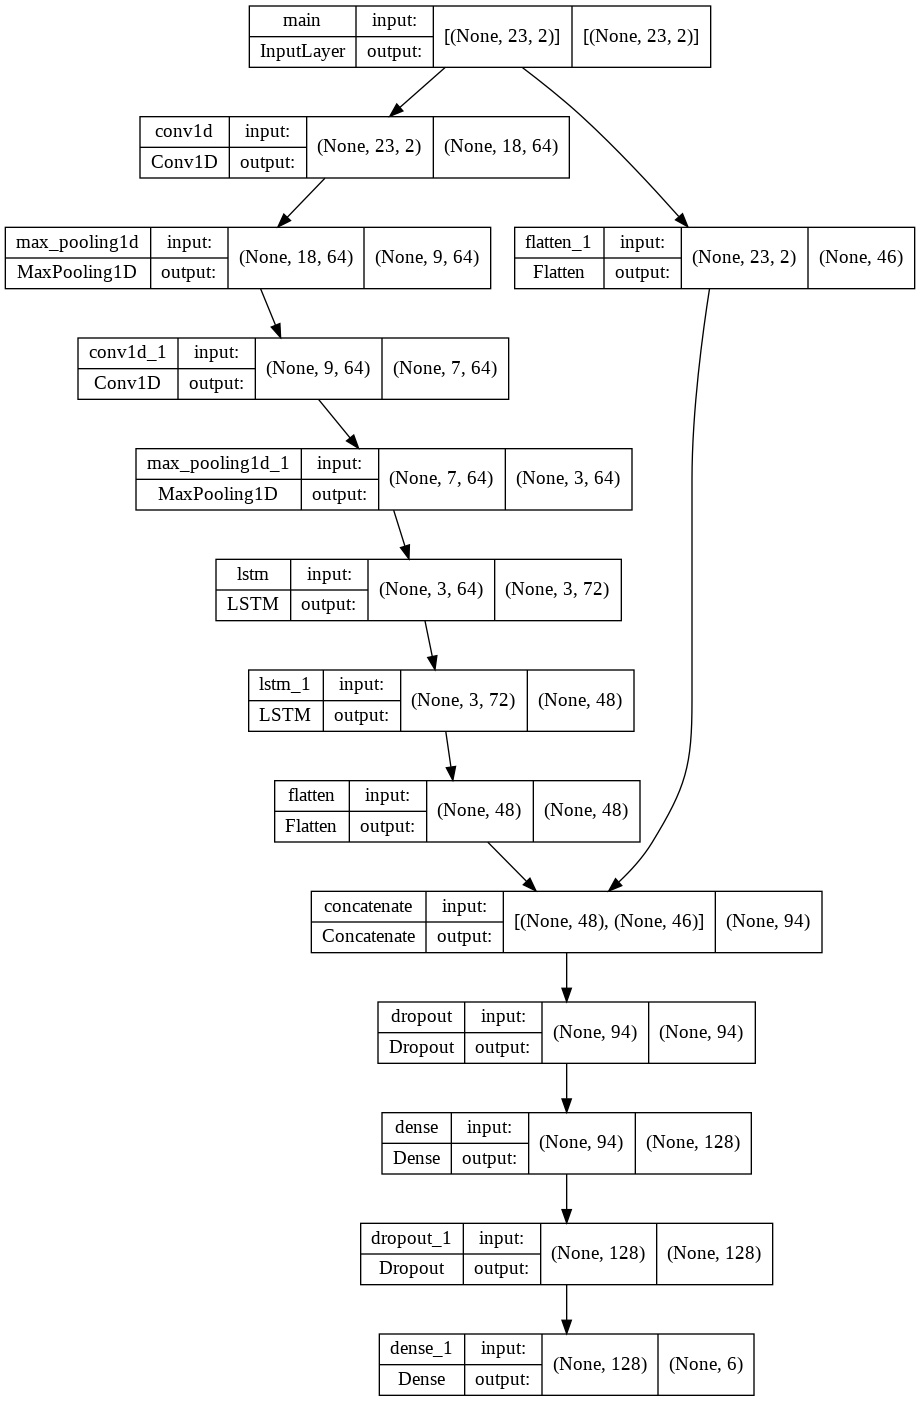

In [ ]:
tf.keras.utils.plot_model(lstm_skip, show_shapes=True)

# Train Models
Run each model for 150 epochs.

In [ ]:
model_configs=dict()
run_model("dnn", dnn_model, model_configs, epochs=4)
run_model("cnn", cnn_model, model_configs, epochs=4)
run_model("lstm", lstm_model, model_configs, epochs=4)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=4)
run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=4)

 Data has been converted to 3d Matrix
Num. of Batchs: 32 in <BatchDataset element_spec=(TensorSpec(shape=(None, 23, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>
 Train tf Dataset generated
Num. of Batchs: 32 in <BatchDataset element_spec=(TensorSpec(shape=(None, 23, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>
 Validaiton tf Dataset generated
Datasets:
 Train
(TensorSpec(shape=(None, 23, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))
 Validation
(TensorSpec(shape=(None, 23, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))


ValueError: ignored

# Evaluation of Training/Validation Results

Loss curves across the models are fairly stable. All models show a flat validation curve while training continues to decline. The LSTM appears to begin to become very overfit from about epoch 100 where the validation loss begins to rise. The lstm_skip also has a point around epoch 50 where the val loss stops decreasing. In all cases this is a sign the models are no longer learning against the validation set. Some options to help improve this are to introduce learning rate decline, or train on longer input sequences.

Plots of the MAE show a similar pattern to the loss plots.


Loss Curves


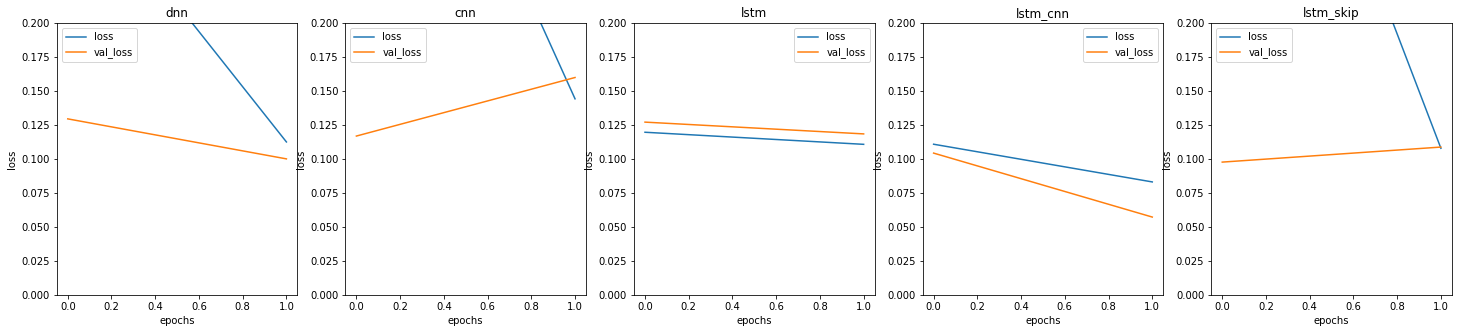

In [ ]:
legend = list()

fig, axs = plt.subplots(1, 5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


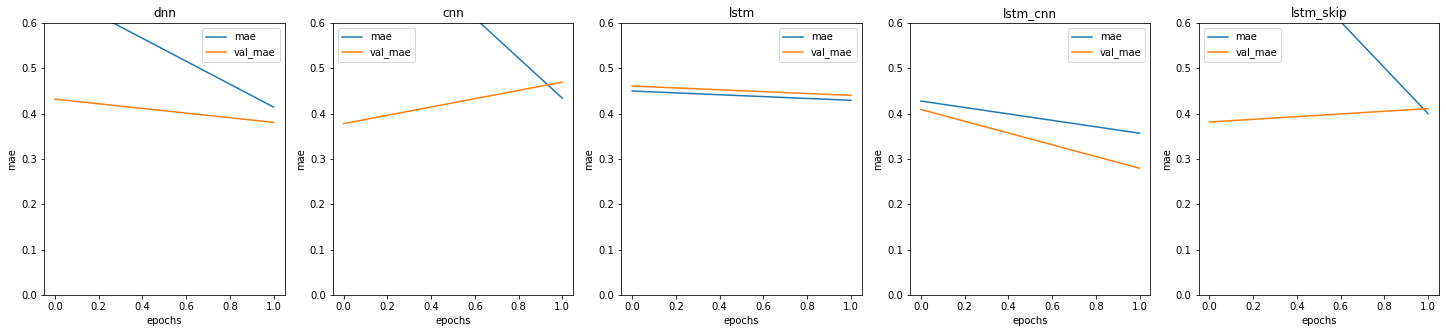

In [ ]:
print("MAE Curves")
fig, axs = plt.subplots(1, 5, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)

# Evaluation of Test Results
The LSTM and the CNN stacked LSTM models clearly outperformed the other four models. Whats surprising is to see how well both a CNN and DNN did on their. LSTM would be expected to perform well because of its ability to learn and remember longer trends in the data.

Comparing to the baseline results the models' performance was poor. The dnn, cnn, lstm, and lstm_cnn models improved against the persistence error (MAE ~ 0.106) but did not improve against the TSO's prediction error (MAE ~0.015, MW error ~443). 

Putting the models' performance in perspective however the results show how with a limited lookback window, and simple features a lstm, and a cnn stacked with an lstm are a good starting choice for architecture.

In [ ]:
names = list()
performance = list()

for key, value in model_configs.items():
    names.append(key)
    mae = value['model'].evaluate(value['test_ds'])
    performance.append(mae[1])
    
performance_df = pd.DataFrame(performance, index=names, columns=['mae'])
performance_df['error_mw'] = performance_df['mae'] * df['total load forecast'].mean()
print(performance_df)    

2/2 [==============================] - 1s 149ms/step - loss: 0.1085 - mae: 0.4226
                mae      error_mw
dnn        0.378565  10869.420700
cnn        0.477647  13714.275762
lstm       0.439680  12624.161571
lstm_cnn   0.261435   7506.366025
lstm_skip  0.422611  12134.065325


# Visualizing Predictions

Plot the actual and predicted 24 hour intervals. Below is the first 14 days of predictions. Interesting to note how the LSTM appears to oscilate over a longer frequency compared with the other models. The CNN also seems to capture the intra day oscillations (within the 24 hour period). Looking at the CNN stacked LSTM we can see how these two characteristics of the model's learning combine.

First Two Weeks of Predictions


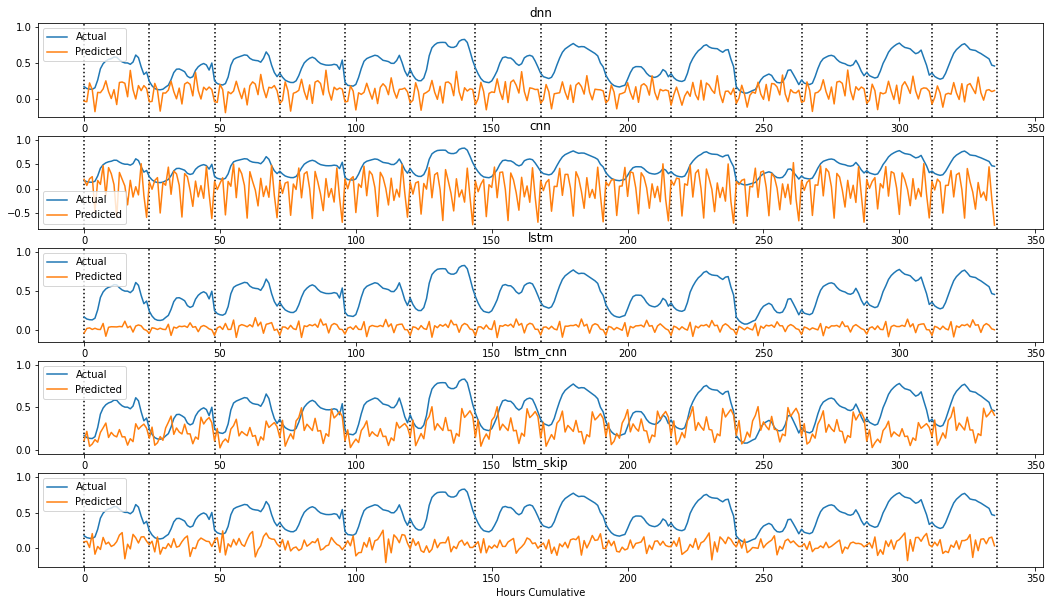

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(18, 10))
days = 14

vline = np.linspace(0, days*24, days+1)

for (key, val), ax in zip(model_configs.items(), axs):

    test = val['test_ds']
    preds = val['model'].predict(test)

    xbatch, ybatch = iter(test).get_next()

    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])

plt.xlabel("Hours Cumulative")
print('First Two Weeks of Predictions')